In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

sns.set(rc = {"figure.figsize":(16, 9)})

class OnlineData:

    def __init__(self, filename):
        self.filename = filename
        self.f = open(filename, 'r')
        self.TotalQ = 1
        self.Qnow = np.array([0])
        self.Pnow = np.array([0])
 
    def __next__(self):
        line = next(self.f)[:-1]
        if len(line) < 1:
            return None
        Q_, P_ = np.array([z[1:-1].split(",") for z in line.split("\t")
                          ]).astype(float).astype(int).T
        self.Qnow = Q_
        self.Pnow = P_
        CS = np.cumsum(P_ * np.ediff1d(Q_, to_begin=Q_[0]))

        self.TotalQ = sum(Q_)

        def F(Q):
            if Q <= Q_[0]:
                return P_[0] * Q
            if Q > sum(Q_):
                return None
            i = np.searchsorted(Q_, Q)
            return CS[i - 1] + (Q - Q_[i - 1]) * P_[i]

        self.F = F
        return self.F

    def __iter__(self):
        return self

    def close(self):
        self.f.close()

In [20]:
def deltaV(P1: np.array, P2: np.array, Q1: np.array, Q2: np.array):
    volume = 0
    total_price = 0

    for i in range(len(Q2)):
        if Q2[i] == 0:
            for j in range(len(Q1)):
                if P1[j] == P2[i]:
                    volume += Q1[j]
                    total_price += Q1[j] * P1[j]
                    break
        else:
            for j in range(len(Q1)):
                if P1[j] == P2[i]:
                    volume += abs(Q1[j] - Q2[j])
                    total_price += (abs(Q1[j] - Q2[j])) * P2[j]
                    break
            break
    
    return volume, total_price
    

In [26]:
def MIdQ(bidfilename: str,
               dQfilename: str,
               depth: int):
    
    it1 = OnlineData(bidfilename)
    it2 = OnlineData(bidfilename)

    fPrice2 = next(it2)
    fPrice1 = next(it1)
    fPrice2 = next(it2)

    dQ = open(dQfilename, 'w+')
    dQ.write("Time," + "PriceChange," + "Loses," + "volume\n")


    for i in range(depth):
        if(i > 100):
            if it2.Qnow[0] == 0:
                # tildS = Price1(volume) / volume

                Price2 = it2.Pnow[0]
                Price1 = it1.Pnow[0]
                volume = 0
                total_price = 0
                P1 = it1.Pnow
                Q1 = it1.Qnow
                P2 = it2.Pnow
                Q2 = it2.Qnow

                bpp = (Price2 - Price1) / Price2 - 1

                
                volume, total_price = deltaV(P1, P2, Q1, Q2)

                # print(i)
                # print(volume, total_price)
                # print(*zip(P1, Q1))
                # print(*zip(P2, Q2))

                if(volume > 0 and bpp > 0.001):
                    dQ.write(str(i) + ", " 
                        + str(((Price2 - Price1)/Price1 * 10000)) + ", " 
                         + str((total_price - volume * Price1) / volume) + ", " 
                        + str(volume / 142266100 * 10000) + "\n")
                
        
        fPrice1 = next(it1)
        fPrice2 = next(it2)
        
    dQ.close()

In [27]:
MIdQ("DataForImpact/bid_22_10_03.tsv", "DataForImpact/BIGdQI_10bp.csv", 1500000)

In [84]:
import pandas as pd
df = pd.read_csv("DataForImpact/dQI.csv")

array([[<Axes: title={'center': 'Time'}>,
        <Axes: title={'center': ' Impact'}>],
       [<Axes: title={'center': ' DeltaQ'}>, <Axes: >]], dtype=object)

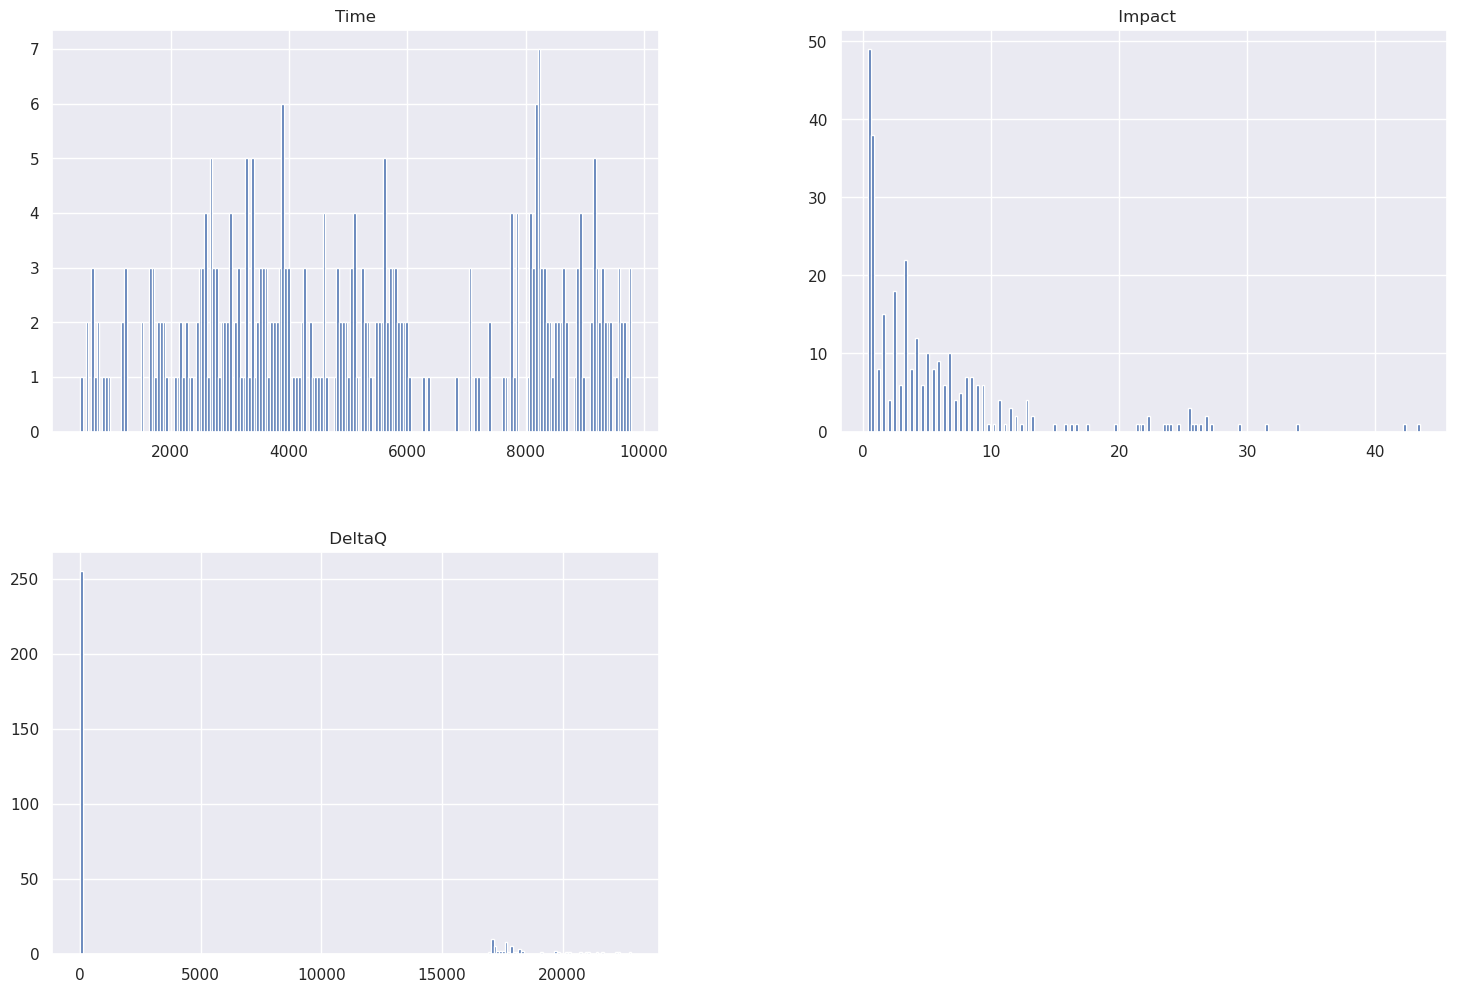

In [86]:
df.iloc[:, :].hist(figsize=(18, 12), bins=200)